# StockX Data Project: Attempting to Predict Sale Prices

This project was inspired by my personal interest in the sneaker game, as well as the work conducted by Sameen Salam in his project last year at the Institute for Advanced Analytics. Using this inspiration, I hoped to find some significant results and practice my modeling abilities through this project.

The main sections of this notebook include exploring the data, engineering new features, different modeling approaches, and final conclusions/results.

# 1. Exploratory Data Analysis

We first need to pull in our stocks data set and import any libraries needed for the analysis. The data consists of a random sample of all Off-White and Yeezy 350 sales between the end of 2017 to beginning of 2019. You can view the full details about the 2019 StockX Data Challenge at the link here: https://stockx.com/news/the-2019-data-contest/

In [63]:
# Importing the necessary libraries for the entire file
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import regressors
from regressors import stats as reg
import requests

# Direct to the folder with the files for importing
os.chdir("C:\\Users\\jorda\\OneDrive\\Documents\\IAA Files and Documents\\Side Project Files\\StockX")

In [64]:
# Load in our data set
shoes = pd.read_csv("StockX-Data-Contest-2019-3.csv")

In [65]:
# Take a glance at our data columns
shoes.head(n=10)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,9/24/16,11.0,California
1,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,11/23/16,11.0,California
2,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,11/23/16,11.0,California
3,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,11/23/16,11.5,Kentucky
4,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2/11/17,11.0,Rhode Island
5,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$798,$220,2/11/17,8.5,Michigan
6,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-White,$784,$220,12/17/16,11.0,California
7,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Cream-White,$460,$220,4/29/17,10.0,New York
8,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Cream-White,$465,$220,4/29/17,11.0,Kansas
9,9/1/17,Yeezy,Adidas-Yeezy-Boost-350-V2-Cream-White,$465,$220,4/29/17,11.0,Florida


Our data currently includes 8 columns:
    - the date the shoe was ordered
    - the brand of the shoe
    - the actual name of the shoe
    - the sale price aka the price the shoe resold for
    - the retail price aka the first price for the shoe when it came out
    - the date the shoe was released
    - the size of the shoe
    - the state that the buyer bought the shoe from

In [66]:
# Cleaning the data to have our dollar values to be numeric
shoes[shoes.columns[3:5]] = shoes[shoes.columns[3:5]].replace('[\$,]', '', regex=True).astype(float)

# Transforming date variable to date time values
shoes['Order Date'] = pd.to_datetime(shoes['Order Date'])
shoes['Release Date'] = pd.to_datetime(shoes['Release Date'])

In [67]:
# Check for missing values
shoes.isnull().sum()

Order Date      0
Brand           0
Sneaker Name    0
Sale Price      0
Retail Price    0
Release Date    0
Shoe Size       0
Buyer Region    0
dtype: int64

Luckily, we have no missing values in our data

In [68]:
# Check the summary stats for each column
shoes.describe()

,Sale Price,Retail Price,Shoe Size
count,99956.000000,99956.00000,99956.000000
mean,446.634719,208.61359,9.344181
std,255.982969,25.20001,2.329588
min,186.000000,130.00000,3.500000
25%,275.000000,220.00000,8.000000
50%,370.000000,220.00000,9.500000
75%,540.000000,220.00000,11.000000
max,4050.000000,250.00000,17.000000


We only have 3 numeric values that generate these summary stats, but it helps give us a better idea of the range of values these columns take on

In [69]:
# Checking the types of our data
shoes.dtypes

Order Date      datetime64[ns]
Brand                   object
Sneaker Name            object
Sale Price             float64
Retail Price           float64
Release Date    datetime64[ns]
Shoe Size              float64
Buyer Region            object
dtype: object

All of our data types look good now for what the column should represent

Text(2000, 20000, '$\\mu=446, std=255$')

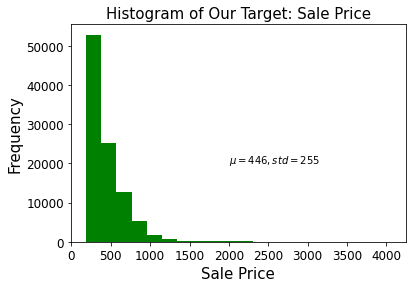

In [70]:
# Plotting some distributions of our target variable
shoes['Sale Price'].hist(bins=20, grid=False, xlabelsize=12, ylabelsize=12, color='green')
plt.xlabel("Sale Price", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.title("Histogram of Our Target: Sale Price", fontsize=15)
plt.text(2000, 20000, r'$\mu=446, std=255$')

Based on our histogram plot, we can see our target is right skewed, meaning we have a higher number of smaller sales prices and fewer number of larger sales prices. This will probably effect our assumption of normality when we conduct a linear regression down the line.

Text(0, 0.5, 'Frequency')

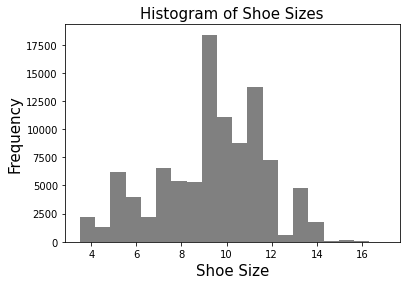

In [71]:
# Plotting some distributions of shoe sizes
plt.hist(shoes['Shoe Size'], bins=20, color='grey')
plt.title('Histogram of Shoe Sizes', fontsize=15)
plt.xlabel('Shoe Size', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

From our histogram, we can see that in our sample of data people are buying sizes 9-12 the most often, which confirms what we typically see when new shoes come out

Text(0, 0.5, 'Sale Price')

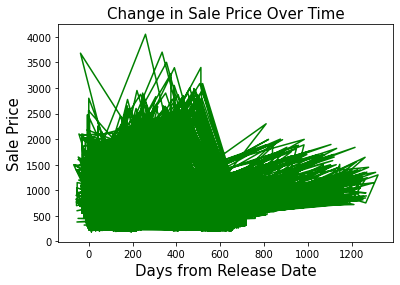

In [72]:
# Plotting the change over time of sale prices
plt.plot(shoes['Order Date'].sub(shoes['Release Date'], axis=0)/np.timedelta64('1','D') , shoes['Sale Price'], color='green')
plt.title('Change in Sale Price Over Time', fontsize=15)
plt.xlabel('Days from Release Date', fontsize=15)
plt.ylabel('Sale Price', fontsize=15)

Not the prettiest chart, but this allows us to see whether or not shoes are decreasing in sale price as the time from when they were released increases. We can see here that it does trend slightly up as you go up until about 2 years, and then it begins to decrease.

## 2. Feature Engineering

In [73]:
# Feature engineering variables that I think may be predictive of sale price
shoes['Price Difference'] = shoes['Sale Price'] - shoes['Retail Price']

shoes['Price_Ratio'] = shoes['Sale Price'] / shoes['Retail Price']

shoes['Difference_in_Date'] = shoes['Order Date'].sub(shoes['Release Date'], axis=0)/np.timedelta64('1','D') 

shoes['Order_Day'] = shoes['Order Date'].dt.day_name()

shoes['Release_Day'] = shoes['Release Date'].dt.day_name()

shoes['Order Month'] = shoes['Order Date'].dt.month_name()

shoes['Release Month'] = shoes['Release Date'].dt.month_name()

shoes["Color_Black"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Black' in x.split("-") else 0)

shoes["Color_Blue"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Blue' in x.split("-") else 0)

shoes["Yeezy_Boost350"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Boost' in x.split("-") else 0)

shoes["Air_Max"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Max' in x.split("-") else 0)

shoes["Presto"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Presto' in x.split("-") else 0)

shoes["Zoom_Fly"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Zoom' in x.split("-") else 0)

shoes["Blazer"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Blazer' in x.split("-") else 0)

shoes["Air_Force"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Force' in x.split("-") else 0)

shoes["Jordan_1"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'Jordan' in x.split("-") else 0)

shoes["Yeezy_V2"] = shoes['Sneaker Name'].apply(lambda x : 1 if 'V2' in x.split("-") else 0)

There are many additional features that can be engineered, however, I opted for these to start based on prior knowledge

In [74]:
# Double check that our new columns are the right data type
shoes.dtypes

Order Date            datetime64[ns]
Brand                         object
Sneaker Name                  object
Sale Price                   float64
Retail Price                 float64
Release Date          datetime64[ns]
Shoe Size                    float64
Buyer Region                  object
Price Difference             float64
Price_Ratio                  float64
Difference_in_Date           float64
Order_Day                     object
Release_Day                   object
Order Month                   object
Release Month                 object
Color_Black                    int64
Color_Blue                     int64
Yeezy_Boost350                 int64
Air_Max                        int64
Presto                         int64
Zoom_Fly                       int64
Blazer                         int64
Air_Force                      int64
Jordan_1                       int64
Yeezy_V2                       int64
dtype: object

In [75]:
# Double check our summary stats look good
shoes.describe()

,Sale Price,Retail Price,Shoe Size,Price Difference,Price_Ratio,Difference_in_Date,Color_Black,Color_Blue,Yeezy_Boost350,Air_Max,Presto,Zoom_Fly,Blazer,Air_Force,Jordan_1,Yeezy_V2
count,99956.000000,99956.00000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000,99956.000000
mean,446.634719,208.61359,9.344181,238.021129,2.248245,183.708722,0.095692,0.139381,0.721938,0.033915,0.043649,0.043189,0.036236,0.024871,0.057055,0.717386
std,255.982969,25.20001,2.329588,266.133179,1.508563,232.354142,0.294170,0.346346,0.448047,0.181011,0.204314,0.203283,0.186878,0.155733,0.231949,0.450273
min,186.000000,130.00000,3.500000,-34.000000,0.845455,-69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,275.000000,220.00000,8.000000,58.000000,1.263636,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,370.000000,220.00000,9.500000,154.000000,1.704545,56.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,540.000000,220.00000,11.000000,342.000000,2.613636,345.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4050.000000,250.00000,17.000000,3860.000000,21.315789,1321.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
# Double check we have no missing values
shoes.isnull().sum()

Order Date            0
Brand                 0
Sneaker Name          0
Sale Price            0
Retail Price          0
Release Date          0
Shoe Size             0
Buyer Region          0
Price Difference      0
Price_Ratio           0
Difference_in_Date    0
Order_Day             0
Release_Day           0
Order Month           0
Release Month         0
Color_Black           0
Color_Blue            0
Yeezy_Boost350        0
Air_Max               0
Presto                0
Zoom_Fly              0
Blazer                0
Air_Force             0
Jordan_1              0
Yeezy_V2              0
dtype: int64

In [77]:
# Exporting the updated stockx data to use in a Tableau dashboard (go check it out!)
shoes.to_csv("stockx_data_updated.csv", index=False)

## 3. Modeling

For our modeling, we are going to start with a linear regression model since we are trying to predict the sale price of a shoe (a continuous target). We will do one model for yeezys and one model for off-whites since they may have different predictors that contribute to an increase or decrease in sale price. We will then move to a random forest regressor to see if we can more accurately predict sale prices using different models. We will use the MAPE or mean absolute precent error to compare the results of our models. We will use MAPE as it has good interpretability and is easier to understand in a business sense. We also know that are target is strictly positive (cannot have negative sale prices) so that makes MAPE a good metric candidate. 

For linear regression, we need to meet 4 assumptions that we will evaluate after running the model:
    1. There exists a linear relationship between x and y
    2. The residuals are independent
    3. The residuals have constant variance
    4. The residuals of the model are normaly distributed

In [78]:
# Need to first split data into yeezy and off white data to build separate models for them
shoes_yeezy = shoes[shoes['Brand'] == ' Yeezy']
shoes_ow = shoes[shoes['Brand'] == 'Off-White']

In [79]:
# Dropping columns that are captured by other variables for each of our data sets
shoes_yeezy = shoes_yeezy.drop(columns=['Shoe Size', 'Difference_in_Date', 'Release Date', 'Price_Ratio', 'Order Date', 'Price Difference', 'Order Month', 'Order_Day', 'Sneaker Name', 'Buyer Region', 'Brand', 'Air_Max', 'Presto', 'Zoom_Fly', 'Blazer', 'Air_Force', 'Jordan_1', 'Yeezy_Boost350'])
shoes_ow = shoes_ow.drop(columns=['Shoe Size', 'Difference_in_Date', 'Release Date', 'Price_Ratio', 'Order Date', 'Price Difference', 'Order Month', 'Order_Day', 'Sneaker Name', 'Buyer Region', 'Brand', 'Yeezy_Boost350', 'Yeezy_V2'])

Because we would be predicting sale price BEFORE a shoe comes out, we need to eliminate a lot of our features since we would not know this information before resell. We also eliminate some variables based on potential multicollinearity issues.

In [80]:
# Creating dummy variables for our categorical variables so the model can handle them
shoes_yeezy = pd.get_dummies(shoes_yeezy)
shoes_ow = pd.get_dummies(shoes_ow)

In [81]:
# Create objects x and y to separate our predictors from the target for both data sets (predicting sale price)
# Yeezy variables
x_yeezy = shoes_yeezy.drop('Sale Price', axis=1)
y_yeezy = shoes_yeezy['Sale Price']

# Off-white variables
x_ow = shoes_ow.drop('Sale Price', axis=1)
y_ow = shoes_ow['Sale Price']

# Run train_test_split to create a train/test data set for the x and y variables for our yeezy and off-white data sets
# We opt for a 80/20 split because we have a decent amount of data but want to make sure we have enough to train on
x_train_yeezy, x_test_yeezy, y_train_yeezy, y_test_yeezy = train_test_split(x_yeezy, y_yeezy, test_size = 0.20, random_state=50)
x_train_ow, x_test_ow, y_train_ow, y_test_ow = train_test_split(x_ow, y_ow, test_size = 0.20, random_state=50)

### We can now start with running the Yeezy Linear Regression Model

In [82]:
# Looking at our correlations between predictors and target for yeezy data to make sure there are no issues
shoes_yeezy.corr(method='pearson')

,Sale Price,Retail Price,Color_Black,Color_Blue,Yeezy_V2,Release_Day_Friday,Release_Day_Saturday,Release_Day_Thursday,Release_Day_Tuesday,Release_Day_Wednesday,Release Month_April,Release Month_August,Release Month_December,Release Month_February,Release Month_June,Release Month_November,Release Month_September
Sale Price,1.000000,-0.384812,0.562317,0.050712,-0.384812,-0.163592,0.033037,-0.138260,0.141240,0.271368,-0.188468,0.135160,0.094433,0.138235,-0.250721,0.082465,0.248621
Retail Price,-0.384812,1.000000,-0.191362,0.030633,1.000000,-0.056075,0.043419,0.021695,-0.391184,0.019058,0.030254,-0.455794,0.017943,-0.024838,0.002131,0.013892,0.006640
Color_Black,0.562317,-0.191362,1.000000,-0.073303,-0.191362,-0.021542,-0.062189,-0.051914,-0.005940,0.195105,-0.072395,0.190475,-0.002694,0.145287,-0.082955,-0.005784,-0.015890
Color_Blue,0.050712,0.030633,-0.073303,1.000000,0.030633,-0.112352,0.193967,-0.104736,-0.011983,-0.092007,-0.146057,-0.013962,0.663275,-0.164843,-0.167361,-0.251559,-0.032058
Yeezy_V2,-0.384812,1.000000,-0.191362,0.030633,1.000000,-0.056075,0.043419,0.021695,-0.391184,0.019058,0.030254,-0.455794,0.017943,-0.024838,0.002131,0.013892,0.006640
Release_Day_Friday,-0.163592,-0.056075,-0.021542,-0.112352,-0.056075,1.000000,-0.579234,-0.079569,-0.009104,-0.069899,-0.110961,-0.010607,-0.169390,-0.107888,-0.127146,0.432913,-0.024354
Release_Day_Saturday,0.033037,0.043419,-0.062189,0.193967,0.043419,-0.579234,1.000000,-0.539968,-0.061780,-0.474345,0.191565,0.018313,-0.361780,0.204592,0.219507,-0.142207,0.042046
Release_Day_Thursday,-0.138260,0.021695,-0.051914,-0.104736,0.021695,-0.079569,-0.539968,1.000000,-0.008487,-0.065160,-0.103439,-0.009888,0.469738,-0.116743,-0.118527,-0.178157,-0.022704
Release_Day_Tuesday,0.141240,-0.391184,-0.005940,-0.011983,-0.391184,-0.009104,-0.061780,-0.008487,1.000000,-0.007455,-0.011835,-0.001131,0.053744,-0.013357,-0.013561,-0.020384,-0.002598
Release_Day_Wednesday,0.271368,0.019058,0.195105,-0.092007,0.019058,-0.069899,-0.474345,-0.065160,-0.007455,1.000000,-0.090868,-0.008687,0.310618,-0.102555,-0.104122,-0.059861,-0.019944


In [83]:
# Create the linear model: lm1 for our yeezy data
lm1_yeezy = sm.OLS(y_train_yeezy, x_train_yeezy).fit()

# Inspect the results
print(lm1_yeezy.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale Price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     7879.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:23:32   Log-Likelihood:            -3.3968e+05
No. Observations:               57729   AIC:                         6.794e+05
Df Residuals:                   57715   BIC:                         6.795e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Retail Price              

Lets examine some of the results from this model:

<br> **R Squared/Adjusted R Squared:** the model explains 64% of the variability of the response data around its mean
<br> **Durbin Watson:** A durbin watson value of 1.98 indicates we have no issue of autocorrelation in our model
<br> **Kurtosis:** A value of 21.821 indicates we have very heavy "tails" in our distribution (to be expected)
<br> **AIC:** 679400; The likelihood of the model to predict/estimate future values (used for model comparison)
<br> **BIC:** 679400; Similar to our AIC value, used for model comparison
<br> **P Values:** All of our p values for our variables seem significant except for the Release Day of Tuesday (we are using a 0.005 cutoff for our p values due to our sample size and wanting a fair amount of evidence)

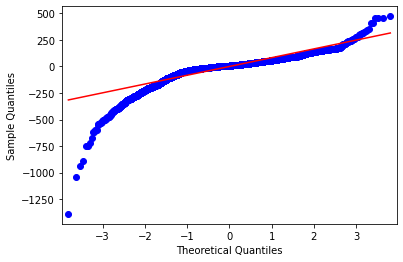

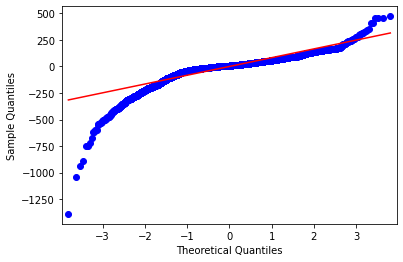

In [84]:
# Getting test predictions
test_preds_yeezy1 = lm1_yeezy.predict(x_test_yeezy)

# Calculating the residuals
residuals_yeezy1 = test_preds_yeezy1 - y_test_yeezy

# Making QQ-plot of residuals (to check again for normality)
sm.qqplot(residuals_yeezy1,line="s")

In [85]:
#Calculate the MAPE
lm1_yeezy_mape = np.mean(100 * abs((residuals_yeezy1/y_test_yeezy)))
lm1_yeezy_mape

13.706230384857268

### Now we can repeat the same process for Off-White Linear Regression

In [86]:
#Looking at the correlation values for each predictor relative to each other and the target
shoes_ow.corr(method='pearson')

,Sale Price,Retail Price,Color_Black,Color_Blue,Air_Max,Presto,Zoom_Fly,Blazer,Air_Force,Jordan_1,...,Release Month_April,Release Month_August,Release Month_December,Release Month_February,Release Month_July,Release Month_June,Release Month_March,Release Month_November,Release Month_October,Release Month_September
Sale Price,1.000000,0.085411,-0.203276,0.239790,-0.026162,0.111650,-0.443259,-0.079355,-0.153419,0.538312,...,-0.058506,0.004151,-0.183345,-0.087316,0.047531,0.098397,0.139687,-0.219041,-0.200615,0.449836
Retail Price,0.085411,1.000000,0.095431,0.143706,-0.079574,-0.252888,-0.004374,-0.578055,-0.091255,0.163213,...,0.526276,-0.188019,-0.078528,-0.133493,-0.158029,0.201940,0.445319,-0.021582,-0.420313,-0.011713
Color_Black,-0.203276,0.095431,1.000000,-0.260432,0.038675,0.177353,0.176897,-0.225344,0.095908,-0.295783,...,-0.143446,-0.178434,0.147726,0.143291,0.463210,-0.173135,0.317839,-0.214740,0.071751,-0.202647
Color_Blue,0.239790,0.143706,-0.260432,1.000000,-0.166738,-0.193047,-0.191838,-0.173174,-0.140212,0.880483,...,-0.110236,-0.137124,-0.123866,-0.101904,-0.120635,0.858466,-0.111517,-0.165025,-0.201484,-0.155732
Air_Max,-0.026162,-0.079574,0.038675,-0.166738,1.000000,-0.160830,-0.159823,-0.144274,-0.116813,-0.189371,...,-0.091839,-0.029484,-0.103194,0.611165,-0.100502,-0.194228,-0.092906,0.046716,0.017715,0.092282
Presto,0.111650,-0.252888,0.177353,-0.193047,-0.160830,1.000000,-0.185041,-0.167038,-0.135244,-0.219251,...,-0.106330,0.532411,-0.119477,-0.098294,0.624899,-0.224874,-0.107565,-0.159177,-0.194345,0.039641
Zoom_Fly,-0.443259,-0.004374,0.176897,-0.191838,-0.159823,-0.185041,1.000000,-0.165992,-0.134398,-0.217878,...,-0.105665,-0.131437,-0.118729,-0.097678,-0.115632,0.091863,-0.106892,0.390641,0.131055,-0.149273
Blazer,-0.079355,-0.578055,-0.225344,-0.173174,-0.144274,-0.167038,-0.165992,1.000000,-0.121322,-0.196681,...,-0.095384,-0.008797,-0.107178,-0.088175,-0.104382,-0.201725,-0.096492,-0.142791,0.634288,0.037702
Air_Force,-0.153419,-0.091255,0.095908,-0.140212,-0.116813,-0.135244,-0.134398,-0.121322,1.000000,-0.159245,...,-0.077229,-0.096066,0.883416,-0.071392,-0.084514,-0.163329,-0.078126,0.081244,-0.141155,-0.109102
Jordan_1,0.538312,0.163213,-0.295783,0.880483,-0.189371,-0.219251,-0.217878,-0.196681,-0.159245,1.000000,...,-0.125200,-0.155738,-0.140680,-0.115737,-0.137010,0.742822,-0.007834,-0.187425,-0.228834,0.039775


In [87]:
# Create the linear model: lm1 for our off-white data
lm1_ow = sm.OLS(y_train_ow, x_train_ow).fit()

# Inspect the results
print(lm1_ow.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale Price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     3567.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:23:33   Log-Likelihood:            -1.4437e+05
No. Observations:               22235   AIC:                         2.888e+05
Df Residuals:                   22213   BIC:                         2.890e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Retail Price              

Lets examine some of the results from this model:

<br> **R Squared/Adjusted R Squared:** the model explains 77.1% of the variability of the response data around its mean
<br> **Durbin Watson:** A durbin watson value of 2.007 indicates we have no issue of autocorrelation in our model
<br> **Kurtosis:** A value of 20.478 indicates we have very heavy "tails" in our distribution (to be expected)
<br> **AIC:** 288800; The likelihood of the model to predict/estimate future values (used for model comparison)
<br> **BIC:** 289000; Similar to our AIC value, used for model comparison
<br> **P Values:** All of our p values for our variables seem significant except for the Release Month of August, July, and September (we are using a 0.005 cutoff for our p values due to our sample size and wanting a fair amount of evidence)

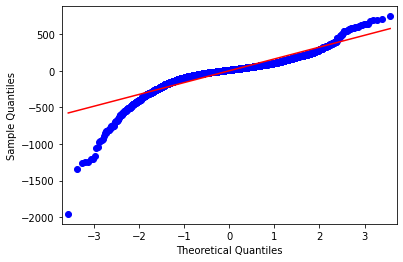

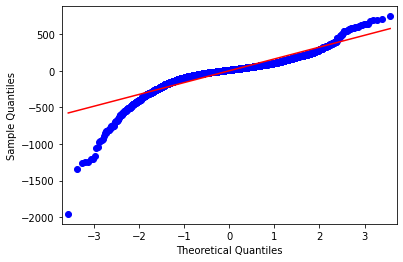

In [88]:
# Getting test predictions
test_preds_ow1 = lm1_ow.predict(x_test_ow)

# Calculating residuals
residuals_ow1 = test_preds_ow1 - y_test_ow

# Making QQ-plot of residuals
sm.qqplot(residuals_ow1,line="s")

In [89]:
# Calculate the MAPE
lm1_ow_mape = np.mean(100 * abs((residuals_ow1/y_test_ow)))
lm1_ow_mape

14.365838808341259

### Second Linear Regression Model for Yeezy using a Transformed Target

In [90]:
# Multiple Linear Regression with sqrt transform (transform our target for ow and yeezy)
y_train_yeezy_sqrt = np.sqrt(y_train_yeezy)
y_train_ow_sqrt = np.sqrt(y_train_ow)
y_test_yeezy_sqrt = np.sqrt(y_test_yeezy)
y_test_ow_sqrt = np.sqrt(y_test_ow)

In [91]:
# Create the linear model: lm2 for our yeezy data
lm2_yeezy = sm.OLS(y_train_yeezy_sqrt, x_train_yeezy).fit()

# Inspect the results
print(lm2_yeezy.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale Price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     7607.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:23:37   Log-Likelihood:            -1.2202e+05
No. Observations:               57729   AIC:                         2.441e+05
Df Residuals:                   57715   BIC:                         2.442e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Retail Price              

Lets examine some of the results from this model:

<br> **R Squared/Adjusted R Squared:** the model explains 63.1% of the variability of the response data around its mean (it has gone down from our first model)
<br> **Durbin Watson:** A durbin watson value of 1.987 indicates we have no issue of autocorrelation in our model
<br> **Kurtosis:** A value of 9.636 indicates we have heavy tails still, but it has gone down a lot
<br> **AIC:** 244100; The likelihood of the model to predict/estimate future values (used for model comparison)
<br> **BIC:** 244100; Similar to our AIC value, used for model comparison
<br> **P Values:** All of our p values for our variables seem significant except for the Release Day of Tuesday still (we are using a 0.005 cutoff for our p values due to our sample size and wanting a fair amount of evidence)

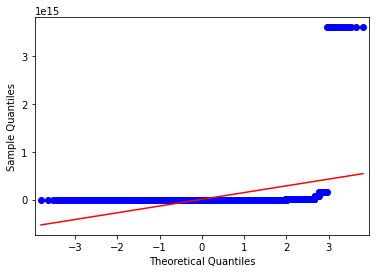

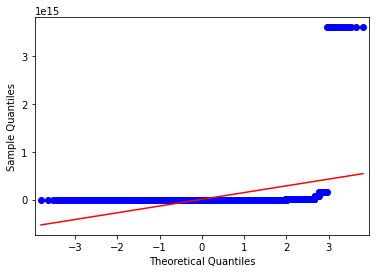

In [92]:
# Getting test predictions
test_preds_yeezy = lm2_yeezy.predict(x_test_yeezy)

# Calculating residuals
residuals_yeezy2 = np.exp(test_preds_yeezy) - y_test_yeezy_sqrt

# Making QQ-plot of the residuals
sm.qqplot(residuals_yeezy2,line="s")

In [93]:
# Calculate the MAPE: On average, the square root transformed linear model is 188821312199.28% off in predicting our sale price (YIKES)
lm2_sqrty_mape = np.mean(100 * abs(residuals_yeezy2/y_test_yeezy_sqrt))
lm2_sqrty_mape

18882131219928.39

### Second Linear Regression Model for Off-White using a Transformed Target

In [94]:
# Create the linear model: lm2 for our off-white data
lm2_ow = sm.OLS(y_train_ow_sqrt, x_train_ow).fit()

# Inspect the results
print(lm2_ow.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale Price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     4155.
Date:                Tue, 16 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:23:50   Log-Likelihood:                -52605.
No. Observations:               22235   AIC:                         1.053e+05
Df Residuals:                   22213   BIC:                         1.054e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Retail Price              

Lets examine some of the results from this model:

<br> **R Squared/Adjusted R Squared:** the model explains 79.7% of the variability of the response data around its mean (it has gone up from our first model)
<br> **Durbin Watson:** A durbin watson value of 2.009 indicates we have no issue of autocorrelation in our model
<br> **Kurtosis:** A value of 8.739 indicates we have heavy tails still, but it has gone down a lot
<br> **AIC:** 105300; The likelihood of the model to predict/estimate future values (used for model comparison)
<br> **BIC:** 105300; Similar to our AIC value, used for model comparison
<br> **P Values:** All of our p values for our variables seem significant except for the Release Month of April, November, and October (we are using a 0.005 cutoff for our p values due to our sample size and wanting a fair amount of evidence)

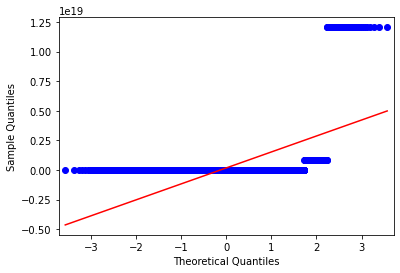

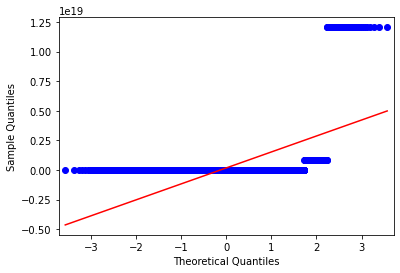

In [95]:
# Getting test predictions
test_preds_ow = lm2_ow.predict(x_test_ow)

# Calculating residuals
residuals_ow2 = np.exp(test_preds_ow) - y_test_ow_sqrt

# Making QQ-plot of the residuals
sm.qqplot(residuals_ow2,line="s")

In [96]:
#Calculate the MAPE: On average, the square root transformed linear model is WAY off in predicting our sale price (Yikes again!)
lm2_sqrtow_mape = np.mean(100 * abs(residuals_ow2/y_test_ow_sqrt))
lm2_sqrtow_mape

4.192091888010598e+17

Based on the results above, we fail to meet the normality assumption even with transformations to the target. We can try using a different model that does not have those same strict assumptions that linear regression does

### Random Forest Model for Yeezy and Off-White 

In [97]:
# Need to split our test into a validation as well to avoid overfitting issues
x_test_yeezy_rf, x_valid_yeezy_rf, y_test_yeezy_rf, y_valid_yeezy_rf = train_test_split(x_test_yeezy,y_test_yeezy,test_size = 0.5)
x_test_ow_rf, x_valid_ow_rf, y_test_ow_rf, y_valid_ow_rf = train_test_split(x_test_ow,y_test_ow,test_size = 0.5)

We want to tune a few hyperparameters for our random forest to try and produce the most accurate results on our data. We will conduct separate tuning for yeezy and off-white data as the hyperparameters may vary.

In [98]:
# Starting with tuning the number of estimators hyper parameter and basing it off of the best MAPE value (yeezy)
n_estimators = [5, 10, 50, 100, 200, 350, 500, 800, 1000]
mape_results = []

for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=50)
    rf.fit(x_train_yeezy, y_train_yeezy)
    valid_pred = rf.predict(x_valid_yeezy_rf)
    valid_error = valid_pred - y_valid_yeezy_rf
    mape = np.mean(100 * abs((valid_error/valid_pred)))
    mape_results.append(mape)

print(mape_results)

[13.595169599077977, 13.596143613795304, 13.596442144837114, 13.595714142846242, 13.595549979902968, 13.595389939321066, 13.595292857380736, 13.595904983220295, 13.595900790032633]


In [99]:
# Starting with tuning the number of estimators hyper parameter and basing it off of the best MAPE value (off white)
n_estimators = [5, 10, 50, 100, 200, 350, 500, 800, 1000]
mape_results = []

for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=50)
    rf.fit(x_train_ow, y_train_ow)
    valid_pred = rf.predict(x_valid_ow_rf)
    valid_error = valid_pred - y_valid_ow_rf
    mape = np.mean(100 * abs((valid_error/valid_pred)))
    mape_results.append(mape)

print(mape_results)

[13.905914512575896, 13.90486086927256, 13.907859406977522, 13.907112276767505, 13.90852810186775, 13.908335648577294, 13.908051870027723, 13.907892617840544, 13.90775591973557]


In [100]:
# Now we can tune the max depth hyper parameter and base it off best MAPE value (yeezy)
max_depth = [5, 10, 25, 40, 50, 75, 100]
mape_results = []

for depth in max_depth:
    rf = RandomForestRegressor(max_depth=depth, random_state=50)
    rf.fit(x_train_yeezy, y_train_yeezy)
    valid_pred = rf.predict(x_valid_yeezy_rf)
    valid_error = valid_pred - y_valid_yeezy_rf
    mape = np.mean(100 * abs((valid_error/valid_pred)))
    mape_results.append(mape)

print(mape_results)

[16.892999097082107, 13.595714142846242, 13.595714142846242, 13.595714142846242, 13.595714142846242, 13.595714142846242, 13.595714142846242]


In [101]:
# Now we can tune the max depth hyper parameter and base it off best MAPE (off-white)
max_depth = [5, 10, 25, 40, 50, 75, 100]
mape_results = []

for depth in max_depth:
    rf = RandomForestRegressor(max_depth=depth, random_state=50)
    rf.fit(x_train_ow, y_train_ow)
    valid_pred = rf.predict(x_valid_ow_rf)
    valid_error = valid_pred - y_valid_ow_rf
    mape = np.mean(100 * abs((valid_error/valid_pred)))
    mape_results.append(mape)

print(mape_results)

[15.212298939451617, 13.99441400623699, 13.907112276767505, 13.907112276767505, 13.907112276767505, 13.907112276767505, 13.907112276767505]


In [102]:
# Lastly, we can tune our max features hyper parameter to determine the best MAPE value (yeezy)
max_features = ['auto', 'sqrt', 0.2, 0.5, 0.75]
mape_results = []

for feat in max_features:
    rf = RandomForestRegressor(max_features=feat, random_state=50)
    rf.fit(x_train_yeezy, y_train_yeezy)
    valid_pred = rf.predict(x_valid_yeezy_rf)
    valid_error = valid_pred - y_valid_yeezy_rf
    mape = np.mean(100 * abs((valid_error/valid_pred)))
    mape_results.append(mape)

print(mape_results)

[13.595714142846242, 13.595714142846242, 13.595714142846242, 13.595714142846242, 13.595714142846242]


In [103]:
# Lastly, we can tune our max features hyper parameter to determine the best MAPE value (off-white)
max_features = ['auto', 'sqrt', 0.2, 0.5, 0.75]
mape_results = []

for feat in max_features:
    rf = RandomForestRegressor(max_features=feat, random_state=50)
    rf.fit(x_train_ow, y_train_ow)
    valid_pred = rf.predict(x_valid_ow_rf)
    valid_error = valid_pred - y_valid_ow_rf
    mape = np.mean(100 * abs((valid_error/valid_pred)))
    mape_results.append(mape)

print(mape_results)

[13.907112276767505, 13.907112276767505, 13.907112276767505, 13.907112276767505, 13.907112276767505]


## Random Forest Model with Tuned Hyperparameters

In [104]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Create model with our optimal hyperparams
rf_yeezy = RandomForestRegressor(n_estimators = 350, max_depth= 10, max_features='auto', random_state = 50)

# Fit the model on training data
rf_yeezy.fit(x_train_yeezy, y_train_yeezy)

RandomForestRegressor(max_depth=10, n_estimators=350, random_state=50)

In [105]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Create model with our optimal hyperparams
rf_ow = RandomForestRegressor(n_estimators = 100, max_depth = 25, max_features='auto', random_state = 50)

# Fit the model on training data
rf_ow.fit(x_train_ow, y_train_ow)

RandomForestRegressor(max_depth=25, random_state=50)

In [106]:
# Generating predictions and MAPE from our random forest on yeezy validation data
valid_pred = rf_yeezy.predict(x_valid_yeezy_rf)
valid_error = valid_pred - y_valid_yeezy_rf
valid_mape = np.mean(100 * abs((valid_error/valid_pred)))
valid_mape

13.595389939321066

In [107]:
# Generating predictions and MAPE from our random forest on off-white validation data
valid_pred = rf.predict(x_valid_ow_rf)
valid_error = valid_pred - y_valid_ow_rf
valid_mape = np.mean(100 * abs((valid_error/valid_pred)))
valid_mape

13.907112276767505

Based on our MAPEs from the linear regression models, we have obtained a smaller MAPE for both the yeezy and off-white data using a random forest model. So far, these are our best candidates.

### Get Feature Importance from Random Forest Models

In [108]:
# Before we get the final pred on the test data we can get a sense of feature importance as well
feature_list = list(x_train_yeezy.columns)

# Get numerical feature importances
importances = list(rf_yeezy.feature_importances_)

# List of tuples with each variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Color_Black Importance: 0.48
Variable: Release Month_September Importance: 0.1
Variable: Yeezy_V2 Importance: 0.09
Variable: Retail Price Importance: 0.08
Variable: Release Month_June Importance: 0.08
Variable: Release Month_April Importance: 0.06
Variable: Release_Day_Friday Importance: 0.04
Variable: Release_Day_Thursday Importance: 0.04
Variable: Release_Day_Saturday Importance: 0.02
Variable: Release_Day_Wednesday Importance: 0.02
Variable: Release Month_November Importance: 0.01
Variable: Color_Blue Importance: 0.0
Variable: Release_Day_Tuesday Importance: 0.0
Variable: Release Month_August Importance: 0.0
Variable: Release Month_December Importance: 0.0
Variable: Release Month_February Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [109]:
# Before we get final pred on the test data we can get a sense of feature importance as well
feature_list = list(x_train_ow.columns)

# Get numerical feature importances
importances = list(rf_ow.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Jordan_1 Importance: 0.37
Variable: Color_Blue Importance: 0.16
Variable: Zoom_Fly Importance: 0.15
Variable: Release Month_June Importance: 0.15
Variable: Release Month_September Importance: 0.06
Variable: Presto Importance: 0.04
Variable: Release Month_December Importance: 0.02
Variable: Retail Price Importance: 0.01
Variable: Release Month_July Importance: 0.01
Variable: Color_Black Importance: 0.0
Variable: Air_Max Importance: 0.0
Variable: Blazer Importance: 0.0
Variable: Air_Force Importance: 0.0
Variable: Release_Day_Friday Importance: 0.0
Variable: Release_Day_Saturday Importance: 0.0
Variable: Release_Day_Thursday Importance: 0.0
Variable: Release_Day_Wednesday Importance: 0.0
Variable: Release Month_April Importance: 0.0
Variable: Release Month_August Importance: 0.0
Variable: Release Month_February Importance: 0.0
Variable: Release Month_March Importance: 0.0
Variable: Release Month_November Importance: 0.0
Variable: Release Month_October Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Rerun of our Random Forest Models with Subsetted Features

In [110]:
# Create the model with our tuned hyperparams
rf_yeezy_important = RandomForestRegressor(n_estimators = 350, max_depth= 10, max_features='auto', random_state = 50)

# Create the dataframes with only our important features
x_train_yeezy_imp = x_train_yeezy.drop(columns=['Color_Blue', 'Release_Day_Tuesday', 'Release Month_August', 'Release Month_December', 'Release Month_February'])
x_valid_yeezy_rf_imp = x_valid_yeezy_rf.drop(columns=['Color_Blue', 'Release_Day_Tuesday', 'Release Month_August', 'Release Month_December', 'Release Month_February'])

# Fit the model on training data
rf_yeezy_important.fit(x_train_yeezy_imp, y_train_yeezy)

RandomForestRegressor(max_depth=10, n_estimators=350, random_state=50)

In [111]:
# Generating predictions from our random forest with only important features on yeezy valid data
valid_pred = rf_yeezy_important.predict(x_valid_yeezy_rf_imp)
valid_error = valid_pred - y_valid_yeezy_rf
valid_mape = np.mean(100 * abs((valid_error/valid_pred)))
valid_mape

13.70490817441715

In [112]:
# Create the model with our tuned hyperparams
rf_ow_important = RandomForestRegressor(n_estimators = 100, max_depth = 25, max_features='auto', random_state = 50)

# Create the dataframes with only our important features
x_train_ow_imp = x_train_ow.drop(columns=['Color_Black', 'Air_Max', 'Blazer', 'Air_Force', 'Release_Day_Friday', 'Release_Day_Saturday', 'Release_Day_Thursday', 'Release_Day_Wednesday', 'Release Month_April', 'Release Month_August', 'Release Month_February', 'Release Month_March', 'Release Month_November', 'Release Month_October'])
x_valid_ow_rf_imp = x_valid_ow_rf.drop(columns=['Color_Black', 'Air_Max', 'Blazer', 'Air_Force', 'Release_Day_Friday', 'Release_Day_Saturday', 'Release_Day_Thursday', 'Release_Day_Wednesday', 'Release Month_April', 'Release Month_August', 'Release Month_February', 'Release Month_March', 'Release Month_November', 'Release Month_October'])

# Fit the model on training data
rf_ow_important.fit(x_train_ow_imp, y_train_ow)

RandomForestRegressor(max_depth=25, random_state=50)

In [113]:
# Generating predictions from our random forest with only important features on off-white valid data
valid_pred = rf_ow_important.predict(x_valid_ow_rf_imp)
valid_error = valid_pred - y_valid_ow_rf
valid_mape = np.mean(100 * abs((valid_error/valid_pred)))
valid_mape

15.071430583524059

So far, our best MAPEs are still from the full random forest model with the tuned hyperparameters. Although the subsetted random forest model did not produce a better MAPE, we can still keep what features were important in mind.

In [114]:
# Test MAPE for yeezy data
test_pred = rf_yeezy.predict(x_test_yeezy_rf)
test_error = test_pred - y_test_yeezy_rf
test_mape = np.mean(100 * abs((test_error/test_pred)))
test_mape

13.738542997770951

In [115]:
# Test MAPE for off-white data
test_pred = rf_ow.predict(x_test_ow_rf)
test_error = test_pred - y_test_ow_rf
test_mape = np.mean(100 * abs((test_error/test_pred)))
test_mape

13.798278776045192

## Using our final Random Forest Models on newly obtained data

Although our test data gives us an indication of how our model would perform on new data, I collected a few new observations based on yeezy shoes that had come out after our original data was recorded. I added in a column for the range of prices that the particular shoe sold for on StockX to see if our model would predict the price of each shoe in the actual range it sold for. There were not many off-white collabs similar to the data we originally had, so we will only be conducting this step for the yeezy model.

In [116]:
# Set our working directory and pull in the new 
os.chdir("C:\\Users\\jorda\\OneDrive\\Documents\\IAA Files and Documents\\Side Project Files\\StockX")
yeezy_new = pd.read_excel("new_data.xlsx", sheet_name = 'Yeezy')

In [117]:
# Dropping the columns that we do not need in the model
y_new = yeezy_new.drop(columns=['Shoe Name', 'Brand', 'Range of Prices'])

In [118]:
# Get dummy values for our categorical variables
y_new = pd.get_dummies(y_new)

In [119]:
# Fit our random forest model to all of our original data
rf_final_yeezy = RandomForestRegressor(n_estimators = 350, max_depth= 10, max_features='auto', random_state = 50)

# Fit the model on our original data (all combined)
rf_final_yeezy.fit(x_yeezy, y_yeezy)

RandomForestRegressor(max_depth=10, n_estimators=350, random_state=50)

In [120]:
# Generate predictions on our new data
yeezy_new_pred = rf_final_yeezy.predict(y_new)

In [121]:
# Output the models predicted values and the actual range of the observations from StockX
Assesment_Yeezy = pd.DataFrame({'Shoe Name':yeezy_new['Shoe Name'], 'Predicted':yeezy_new_pred, 'Actual Range':yeezy_new['Range of Prices']})
Assesment_Yeezy

,Shoe Name,Predicted,Actual Range
0,Glow in the dark,468.185317,573-749
1,Black Reflective,763.496344,961-1223
2,Black Non Reflective,763.496344,464-512
3,Antlia,269.758988,373-469
4,Syth,269.758988,234-684
5,Cloud White,788.625954,318-452
6,Citrin,788.625954,140-332
7,Yeezrell Reflective,468.185317,281-339
8,Yeezrell Non Reflective,287.056282,243-317
9,Yecheil,264.786290,361-457


## 4. Final Conclusions

In conclusion, we found that our random forest models with all features included produced the lowest MAPE value for both the Yeezy and Off-White data. Even though they were lower, our model predictions are still about 14% off from the true value. By looking at our predicted vs actual range list above, we can see the model only predicted 5 out of the 16 observations in the correct range of sale prices. 

Further feature engineering may be necessary in order to help the model learn the differences in certain shoes, such as different colorways, how "hype" the shoe is before it releases, and reflective vs non reflective shoes. For example, looking at the table above we can see that the Black Reflective and Black Non Reflective were predicted to be the same price but the Non Reflective shoes went for way less than the Reflective shoes. By adding in extra features, it could help the model learn to differentiate between these type of shoes and give more accurate prices.

Some of the most important features, based on our random forest models, that influence sale price of shoes were the color black in the title of the shoe name and whether the shoe was a V2 or not for Yeezys and the color blue in the title of the shoe name and whether the shoe was a Jordan 1 or not for Off-Whites.

All in all, this was an extremely fun project to work on to test my skills and see if I could derive any results from an area of interest! This project could be further developed to produce even more accurate predictions but would require more data collection, that is hard to obtain from StockX, or a new target for the project could be used. The possibilities are endless!

<b>Created by: Jordan Strickland, jmstric5@ncsu.edu<b>